# About the project
Juicy, perfectly sun-ripened tomatoes are among the easiest vegetables you can grow in your garden. But taking good care of your crop means keeping an eye out for tomato plant diseases caused by fungi, bacteria, and viruses, which can cause leaf spots and blights.

What we'll be doing in this project is to train a model and predict the type of disease the tomato plant of that particular leaf is suffering and try using a Grad-CAM to see where features are picked up on the leaf.

### About the dataset
In this dataset was taken from [Tomato leaf disease detection](https://www.kaggle.com/datasets/kaustubhb999/tomatoleaf), it has 9760 images across 10 classes.

The data has different types of diseases for tomato leaves.

Here goes the list:

1. Tomato_mosaic_virus
2. Target_Spot
3. Bacterial_spot
4. Tomato_Yellow_Leaf_Curl_Virus
5. Late_blight
6. Leaf_Mold
7. Early_blight
8. Spider_mites Two-spotted_spider_mite
9. Tomato___healthy
10. Septoria_leaf_spot

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import required libraries

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input

In [21]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
SEED = 108

# Build the models

### Custom model

In [ ]:
custom_model = Sequential([
    Conv2D(32, kernel_size = (3,3), activation = 'relu', input_shape = (256, 256, 3) ),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation = 'relu'),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation = 'relu'),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation = 'relu'),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation = 'relu'),
    MaxPooling2D((2,2)),
    Conv2D(48, (3,3), activation = 'relu'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(64, activation = 'relu'),
    Dense(10, activation = 'softmax')
])

custom_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 127, 127, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 62, 62, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 60, 60, 64)        36928     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 30, 30, 64)      

In [ ]:
custom_model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.CategoricalCrossentropy(from_logits = False),
    metrics = ['accuracy']
)

### Pre-trained model InceptionV3

In [ ]:
base = InceptionV3(input_shape=(256,256,3), include_top=False)

87910968/87910968 [==============================] - 0s 0us/step


In [ ]:
for layer in base.layers:
  layer.trainable = False

In [ ]:
X = Flatten()(base.output)
X = Dense(units=512, activation="relu")(X)
X = Dense(units=512, activation="relu")(X)
X = Dense(units=10, activation="softmax")(X)

InceptionV3_model = Model(base.input, X)
InceptionV3_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_18 (Conv2D)             (None, 127, 127, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 127, 127, 32  96         ['conv2d_18[0][0]']              
 alization)                     )                                                           

In [ ]:
InceptionV3_model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.CategoricalCrossentropy(from_logits = False),
    metrics = ['accuracy']
)

# Preprocess the images
The ImageDataGenerator class allows your model to receive new variations of the images at each epoch. But do remember that it only returns the transformed images and does not add it to the set of images that you have.

### Data for custom model

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range=0.4,
                                   width_shift_range=0.3,
                                   shear_range=0.4,
                                   zoom_range=0.4,
                                   horizontal_flip=True,
                                   validation_split=0.2)

test_datagen = ImageDataGenerator(rescale = 1./255,
                                  rotation_range=0.4,
                                  width_shift_range=0.3,
                                  shear_range=0.4,
                                  zoom_range=0.4,
                                  horizontal_flip=True)

custom_train_batches = train_datagen.flow_from_directory(
    directory= "/content/drive/MyDrive/Class ML/tomato/train",
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    seed=SEED,
    subset='training'
)

custom_val_batches = train_datagen.flow_from_directory(
    directory= "/content/drive/MyDrive/Class ML/tomato/train",
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    seed=SEED,
    subset='validation'
)

custom_test_batches = test_datagen.flow_from_directory(
    directory= "/content/drive/MyDrive/Class ML/tomato/val",
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=64,
    seed=SEED
)


### Data for InceptionV3

In [ ]:
InceptionV3_train_datagen = ImageDataGenerator(rotation_range=0.4,
                                   width_shift_range=0.3,
                                   shear_range=0.4,
                                   zoom_range=0.4,
                                   horizontal_flip=True,
                                   validation_split=0.2,
                                   preprocessing_function=preprocess_input)

InceptionV3_test_datagen = ImageDataGenerator(rotation_range=0.4,
                                  width_shift_range=0.3,
                                  shear_range=0.4,
                                  zoom_range=0.4,
                                  horizontal_flip=True,
                                  preprocessing_function=preprocess_input)

InceptionV3_train_batches = InceptionV3_train_datagen.flow_from_directory(
    directory= "/content/drive/MyDrive/Class ML/tomato/train",
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    seed=SEED,
    subset='training'
)

InceptionV3_val_batches = InceptionV3_train_datagen.flow_from_directory(
    directory= "/content/drive/MyDrive/Class ML/tomato/train",
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    seed=SEED,
    subset='validation'
)

InceptionV3_test_batches = InceptionV3_test_datagen.flow_from_directory(
    directory= "/content/drive/MyDrive/Class ML/tomato/val",
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=64,
    seed=SEED
)


Found 8000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
Found 984 images belonging to 10 classes.


In [45]:
class_names = list(custom_train_batches.class_indices.keys())
ref = dict([(value, key) for key, value in custom_train_batches.class_indices.items()])
print(class_names)
print(ref)

['Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus', 'Tomato___healthy']
{0: 'Tomato___Bacterial_spot', 1: 'Tomato___Early_blight', 2: 'Tomato___Late_blight', 3: 'Tomato___Leaf_Mold', 4: 'Tomato___Septoria_leaf_spot', 5: 'Tomato___Spider_mites Two-spotted_spider_mite', 6: 'Tomato___Target_Spot', 7: 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 8: 'Tomato___Tomato_mosaic_virus', 9: 'Tomato___healthy'}


# Training the model

### Model checkpoints

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

InceptionV3_mc = ModelCheckpoint(filepath="/content/drive/MyDrive/Class ML/tomato/InceptionV3_best_model.h5",
                     monitor="val_accuracy",
                     verbose=1,
                     save_best_only=True)

custom_mc = ModelCheckpoint(filepath="/content/drive/MyDrive/Class ML/tomato/custom_best_model_GPU.h5",
                     monitor="val_accuracy",
                     verbose=1,
                     save_best_only=True)

es = EarlyStopping(monitor="val_accuracy",
                   min_delta=0.01,
                   patience=5,
                   verbose=1)

custom_cb = [custom_mc, es]
InceptionV3_cb = [InceptionV3_mc, es]

### Custom fit

In [ ]:
custom_history = custom_model.fit(custom_train_batches,
                              validation_data = custom_val_batches,
                              epochs=100,
                              callbacks=custom_cb)

Epoch 1/100
250/250 [==============================] - ETA: 0s - loss: 2.0329 - accuracy: 0.2383
Epoch 1: val_accuracy improved from -inf to 0.40650, saving model to ./custom_best_model_GPU.h5
250/250 [==============================] - 1509s 6s/step - loss: 2.0329 - accuracy: 0.2383 - val_loss: 1.6681 - val_accuracy: 0.4065
Epoch 2/100
250/250 [==============================] - ETA: 0s - loss: 1.4448 - accuracy: 0.4869
Epoch 2: val_accuracy improved from 0.40650 to 0.60800, saving model to ./custom_best_model_GPU.h5
250/250 [==============================] - 173s 694ms/step - loss: 1.4448 - accuracy: 0.4869 - val_loss: 1.1243 - val_accuracy: 0.6080
Epoch 3/100
250/250 [==============================] - ETA: 0s - loss: 1.1106 - accuracy: 0.6086
Epoch 3: val_accuracy improved from 0.60800 to 0.62400, saving model to ./custom_best_model_GPU.h5
250/250 [==============================] - 171s 686ms/step - loss: 1.1106 - accuracy: 0.6086 - val_loss: 0.9887 - val_accuracy: 0.6240
Epoch 4/100


### InceptionV3 fit

In [ ]:
InceptionV3_history = InceptionV3_model.fit(InceptionV3_train_batches,
                              validation_data = InceptionV3_val_batches,
                              epochs=100,
                              callbacks=InceptionV3_cb)
#The number of steps per epoch for inception is different maybe because of the

Epoch 1/100
125/125 [==============================] - ETA: 0s - loss: 5.9198 - accuracy: 0.4914
Epoch 1: val_accuracy improved from -inf to 0.71050, saving model to ./InceptionV3_best_model.h5
125/125 [==============================] - 196s 2s/step - loss: 5.9198 - accuracy: 0.4914 - val_loss: 0.8641 - val_accuracy: 0.7105
Epoch 2/100
125/125 [==============================] - ETA: 0s - loss: 0.7756 - accuracy: 0.7278
Epoch 2: val_accuracy improved from 0.71050 to 0.76550, saving model to ./InceptionV3_best_model.h5
125/125 [==============================] - 184s 1s/step - loss: 0.7756 - accuracy: 0.7278 - val_loss: 0.6753 - val_accuracy: 0.7655
Epoch 3/100
125/125 [==============================] - ETA: 0s - loss: 0.6578 - accuracy: 0.7724
Epoch 3: val_accuracy improved from 0.76550 to 0.78350, saving model to ./InceptionV3_best_model.h5
125/125 [==============================] - 182s 1s/step - loss: 0.6578 - accuracy: 0.7724 - val_loss: 0.6385 - val_accuracy: 0.7835
Epoch 4/100
125/

# Load the model

### Custom model

In [2]:
from tensorflow.keras.models import load_model
custom_model_test = load_model("latest_custom.h5")

In [ ]:
his = custom_history.history
his.keys()

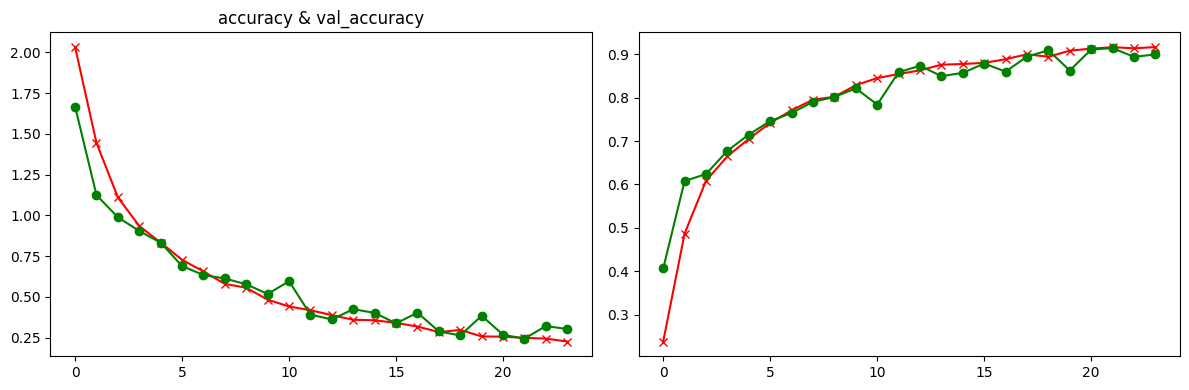

In [39]:
acc = custom_history.history['accuracy']
val_acc = custom_history.history['val_accuracy']
loss = custom_history.history['loss']
val_loss = custom_history.history['val_loss']

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

axes[0].plot(loss, color="red", marker="x")
axes[0].plot(val_loss, color="green", marker="o")
axes[0].set_title('loss & val_loss')
axes[1].plot(acc, color="red", marker="x")
axes[1].plot(val_acc, color="green", marker="o")
axes[1].set_title("accuracy & val_accuracy")

plt.tight_layout()
plt.show();

### InceptionV3 model

In [4]:
from tensorflow.keras.models import load_model
InceptionV3_model_test = load_model("InceptionV3_best_model.h5")

In [41]:
his = InceptionV3_history.history
his.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

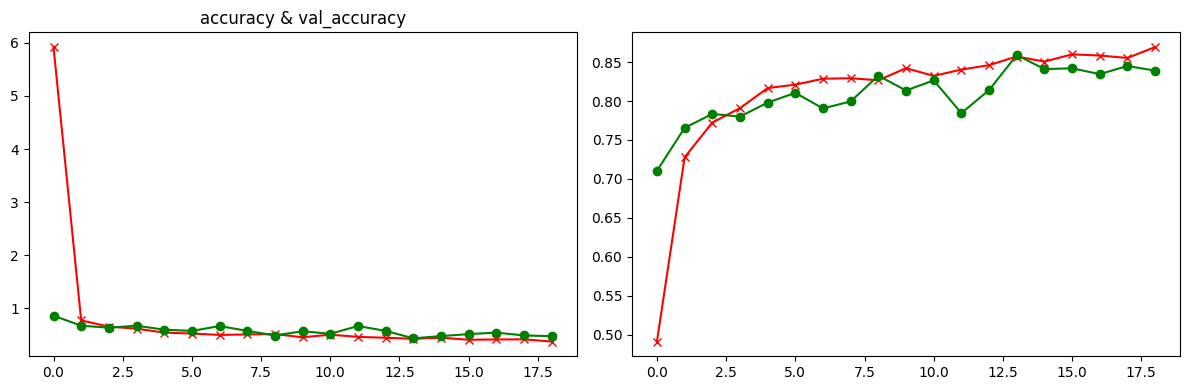

In [42]:
acc = InceptionV3_history.history['accuracy']
val_acc = InceptionV3_history.history['val_accuracy']
loss = InceptionV3_history.history['loss']
val_loss = InceptionV3_history.history['val_loss']

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

axes[0].plot(loss, color="red", marker="x")
axes[0].plot(val_loss, color="green", marker="o")
axes[0].set_title('loss & val_loss')
axes[1].plot(acc, color="red", marker="x")
axes[1].plot(val_acc, color="green", marker="o")
axes[1].set_title("accuracy & val_accuracy")

plt.tight_layout()
plt.show();

# Validate the model

### Custom model

In [49]:
result = custom_model_test.evaluate(custom_test_batches)
result

16/16 [==============================] - 178s 12s/step - loss: 0.2863 - accuracy: 0.9126


[0.28629249334335327, 0.9126016497612]

### InceptionV3 model

In [70]:
result = InceptionV3_model_test.evaluate(InceptionV3_test_batches)
result

16/16 [==============================] - 24s 1s/step - loss: 0.6126 - accuracy: 0.8211


[0.6125605702400208, 0.8211382031440735]

The custom model did a better job generalizing and has better accuracy.

# Area on focus
We will be using Grad CAM to find out where the the InceptionV3 model tries to pick up information to make a prediction.

In [10]:
def get_img_array(img_path):
  test_image = load_img(img_path, target_size=(256,256))
  img = img_to_array(test_image)
  img = preprocess_input(img)
  img_arr = np.array([img])
  return img_arr

In [18]:
def make_gradcam_heatmap(img_arr, model, last_conv_layer_name, pred_index=None):
  grad_model = tf.keras.models.Model(
      [model.input], [model.get_layer(last_conv_layer_name).output, model.output]
  )

  with tf.GradientTape() as tape: # tape holds gradient information
    last_conv_layer_output, pred = grad_model(img_arr)

    if pred_index is None:
      pred_index = tf.argmax(pred[0])

    class_channel = pred[:,pred_index]

  grad = tape.gradient(class_channel, last_conv_layer_output)
  mean_grad = tf.reduce_mean(grad, axis=(0,1,2))

  last_conv_layer_output = last_conv_layer_output[0]
  heatmap = last_conv_layer_output @ mean_grad[..., tf.newaxis]
  heatmap = tf.squeeze(heatmap)
  heatmap = tf.maximum(heatmap,0)/tf.math.reduce_max(heatmap)

  return heatmap.numpy()

### Mask the heatmap on Image

In [29]:
import matplotlib.cm as cm
from IPython.display import Image, display

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.6):
  img = img_to_array(load_img(img_path))
  heatmap = np.uint8(heatmap*255)

  jet = cm.get_cmap("jet")
  jet_colors = jet(np.arange(256))[:, :3]
  jet_heatmap = jet_colors[heatmap]

  jet_heatmap = array_to_img(jet_heatmap)
  jet_heatmap = jet_heatmap.resize((img.shape [1], img.shape [0]))
  jet_heatmap = img_to_array(jet_heatmap)

  superimposed_img = jet_heatmap * alpha + img
  superimposed_img = array_to_img(superimposed_img)
  superimposed_img.save(cam_path)
  display(Image(cam_path))

In [32]:
def image_prediction_and_visualization(path, last_conv_layer_name="conv2d_111", model=InceptionV3_model_test):
  img_array = get_img_array(path)
  heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
  print("Heatmap of the image\n")
  plt.imshow(heatmap)
  plt.show()
  save_and_display_gradcam(path, heatmap)
  a = plt.imread(path)
  plt.imshow(a, cmap="gray")
  print("original image")
  plt.show()


Heatmap of the image



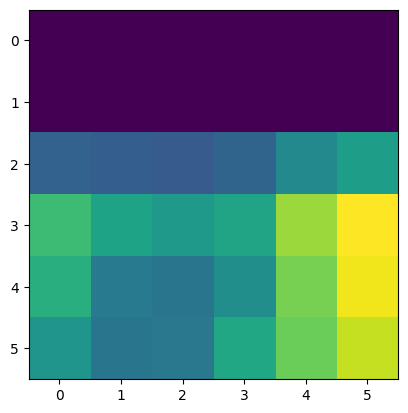

C:\Users\Dhasharadh Reddy\AppData\Local\Temp\ipykernel_31492\3763308466.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


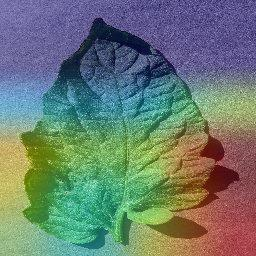

original image


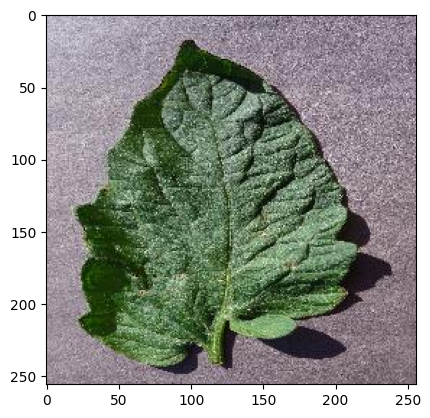

In [36]:
path = "gradcam_test.jpg"
image_prediction_and_visualization(path)